**Datasets:**


*   [VTON-1](https://www.kaggle.com/code/ma00753045/tryon/notebook)
*   [VTON-2](https://www.kaggle.com/datasets/rkuo2000/viton-dataset)

*   [CIHP and ATR](https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz)

*   [LIP](https://drive.google.com/drive/folders/1ZjNrTb7T_SsOdck76qDcd5OHkFEU0C6Q)

*   [ATR, CIHP and LIP](https://drive.google.com/drive/folders/0BzvH3bSnp3E9ZW9paE9kdkJtM3M?resourcekey=0-vgKJX42GVFaAwjhEWAncjQ)

*   [MHP V2](https://drive.google.com/file/d/1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn/view)


**Papers:**

*   [Base Paper on Virtual Try-On](https://www.arxiv-vanity.com/papers/1909.02165/)
*   [Blog on Virtual Try-On (for additional info)](https://www.kdnuggets.com/2020/10/deep-learning-virtual-try-clothes.html)

*   [Multi-Human Parsing on MHP v2.0](https://paperswithcode.com/sota/multi-human-parsing-on-mhp-v20)

**Tutorials:**

* [Live Implementation 1](https://www.youtube.com/watch?v=csYkGeJ5bCM&list=WL&index=7&ab_channel=BrainMentorsPvtLtd)
* [Live Implementation 2](https://www.youtube.com/watch?v=YjWh7QvVH60&ab_channel=TheAIGuy)

* [Human Body Parsing](https://www.youtube.com/watch?v=ng_gAxQnXAY&ab_channel=IdiotDeveloper)

**Demos:**

* [Vue AI](https://vue.ai/products/virtual-dressing-room/)

#**Stage 1: Dataset Collection and Modification**

In [290]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os, sys
import json
from os import listdir
from os.path import isfile, join
import shutil 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from random import randrange
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

import scipy.io

In [291]:
tf.random.set_seed(42)
np.random.seed(42)

In [292]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [293]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")

tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

In [294]:
is_download_vton_dataset = False
is_download_cihp_dataset = False

check_dims_for_cihp_dataset = False

run_model_parsing_0 = False

# unused
is_download_mhp_dataset = False

In [295]:
saved_models_path = '/content/saved_models'

print(os.path.exists(saved_models_path))

if not os.path.exists(saved_models_path):
  os.mkdir(saved_models_path)

True


In [296]:
%%time
# Train Directory

if is_download_vton_dataset:

  !wget https://drive.google.com/file/d/1lHNujZIq6KVeGOOdwnOXVCSR5E7Kv6xv/view
  !gdown 1lHNujZIq6KVeGOOdwnOXVCSR5E7Kv6xv

  !unzip -q /content/ACGPN_traindata.zip -d Train_Dir

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [297]:
%%time
# Test Directory

if is_download_vton_dataset:

  !wget https://drive.google.com/file/d/1tE7hcVFm8Td8kRh5iYRBSDFdvZIkbUIR/view
  !gdown 1tE7hcVFm8Td8kRh5iYRBSDFdvZIkbUIR

  !unzip -q /content/Data_preprocessing.zip -d Test_Dir

  # move directories downloaded as unziped for vton dataset into a single vton directory
  shutil.move('/content/Test_Dir', '/content/VTON/Test_Dir')
  shutil.move('/content/Train_Dir', '/content/VTON/Train_Dir')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [298]:
vton_test_dir = '/content/VTON/Test_Dir'
vton_train_dir = '/content/VTON/Train_Dir'

In [299]:
def get_dir_n_files(root_dir):

  """
  get number of files in a directory and all its subdirectories
  """

  dir_n_files = pd.DataFrame({'Directoy Path':[], 'Sub Directories':[], 'Number of Files':[]})

  for dir_path, dirs, files in os.walk(root_dir):
    dir_n_files = dir_n_files.append({'Directoy Path':dir_path, 'Sub Directories':dirs, 'Number of Files':len(files)}, ignore_index=True)

  dir_n_files['Number of Files'] = dir_n_files['Number of Files'].astype(int)

  return dir_n_files

In [300]:
def get_file_paths_at_index(root_dir, index=0):

  """
  get a list of datapoints at an index from each sub directory
  """

  result_files = []
  for root, dirs, files in os.walk(root_dir):
      if files and len(files) > index:
          result_files.append(os.path.join(root, sorted(files)[index]))

  return sorted(result_files)

In [301]:
# Python3 program to swap elements
# at given positions
 
# Swap function
def swapPositions(list, pos1, pos2):
     
    # popping both the elements from list
    first_ele = list.pop(pos1)  
    second_ele = list.pop(pos2-1)
    
    # inserting in each others positions
    list.insert(pos1, second_ele) 
    list.insert(pos2, first_ele) 
     
    return list

In [302]:
def get_pose_keypoints(file_path):

  # Opening JSON file
  with open(file_path) as json_file:
      data = json.load(json_file)

      return data['people'][0]['pose_keypoints']

In [303]:
def get_files_in_dir(dir_path):
  
  files = sorted([f for f in listdir(dir_path) if isfile(join(dir_path, f))])

  return files

In [304]:
def visualize_vton_dataset_imgs(root_dir, max_range, n_samples=3, figsize=(20, 12)):
 
  # create figure
  fig = plt.figure(figsize=figsize)
  
  # setting values to rows and column variables
  rows = n_samples
  columns = len(list(os.walk(root_dir))[0][1])

  index = 0

  for row_num in range(rows):

    random_index = randrange(max_range)
    
    visualize_paths = get_file_paths_at_index(root_dir, random_index)

    pose_keypoints_path  = visualize_paths[-1]

    # removed pose column, bcz it needs image processing
    visualize_paths = visualize_paths[:-1]

    # swapped position of some columns to display images in better order
    visualize_paths = swapPositions(visualize_paths, 1, 4)
    visualize_paths = swapPositions(visualize_paths, 1, 2)
    visualize_paths = swapPositions(visualize_paths, 2, 3)
  
    img_read_array = []
    
    # create a dictionary containing read image data and image info
    for img_path in visualize_paths:
      
      # img_test = cv2.imread(img_path)
      img = {'img': mpimg.imread(img_path), 'img_name': img_path.split("/")[4], 'file_name': img_path.split("/")[5]}
      img_read_array.append(img)



    # display dictionary of images on a grid
    for img_read_data in img_read_array:

      index += 1

      fig.add_subplot(rows, columns, index,)

      # styling
      plt.rc('font', size=15) 
      # plt.rc('title', size=12)

      plt.imshow(img_read_data['img'])
      plt.title(img_read_data['file_name'], fontdict={'fontsize': 14})

      # remove axes on individual images
      plt.xticks([])
      plt.yticks([])

      
      if index%columns == 1:
        plt.ylabel(str(random_index))

      if row_num == rows-1:
        plt.xlabel(img_read_data['img_name'])


    # handle keypoints here and add img to img_read_array
    index += 1
    fig.add_subplot(rows, columns, index,)
    
    pose_keypoints_array = np.array(get_pose_keypoints(pose_keypoints_path)).reshape(-1, 3)

    pose_keypoints_img = img_read_array[2]['img']
    plt.imshow(pose_keypoints_img)

    # remove axes on individual images
    plt.xticks([])
    plt.yticks([])

    if row_num == rows-1:
        plt.xlabel(pose_keypoints_path.split("/")[3])
    
    i=0
    for x,y,z in pose_keypoints_array: 
        plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
        plt.text(x, y, str(i), color='r', fontsize=10)
        i+=1
    # plt.show()


In [305]:
# Check number of files and directories in test directory 

get_dir_n_files(vton_test_dir)

,Directoy Path,Sub Directories,Number of Files
0,/content/VTON/Test_Dir,"[test_colormask, test_pose, test_edge, test_ma...",0
1,/content/VTON/Test_Dir/test_colormask,[],10000
2,/content/VTON/Test_Dir/test_pose,[],2032
3,/content/VTON/Test_Dir/test_edge,[],2032
4,/content/VTON/Test_Dir/test_mask,[],12000
5,/content/VTON/Test_Dir/test_img,[],2032
6,/content/VTON/Test_Dir/test_label,[],2032
7,/content/VTON/Test_Dir/test_color,[],2032


In [306]:
# Check number of files and directories in train directory 

get_dir_n_files(vton_train_dir)

,Directoy Path,Sub Directories,Number of Files
0,/content/VTON/Train_Dir,"[train_img, train_colormask, train_label, trai...",0
1,/content/VTON/Train_Dir/train_img,[],14221
2,/content/VTON/Train_Dir/train_colormask,[],50000
3,/content/VTON/Train_Dir/train_label,[],14221
4,/content/VTON/Train_Dir/train_edge,[],14221
5,/content/VTON/Train_Dir/train_mask,[],12000
6,/content/VTON/Train_Dir/train_color,[],14221
7,/content/VTON/Train_Dir/train_pose,[],14221


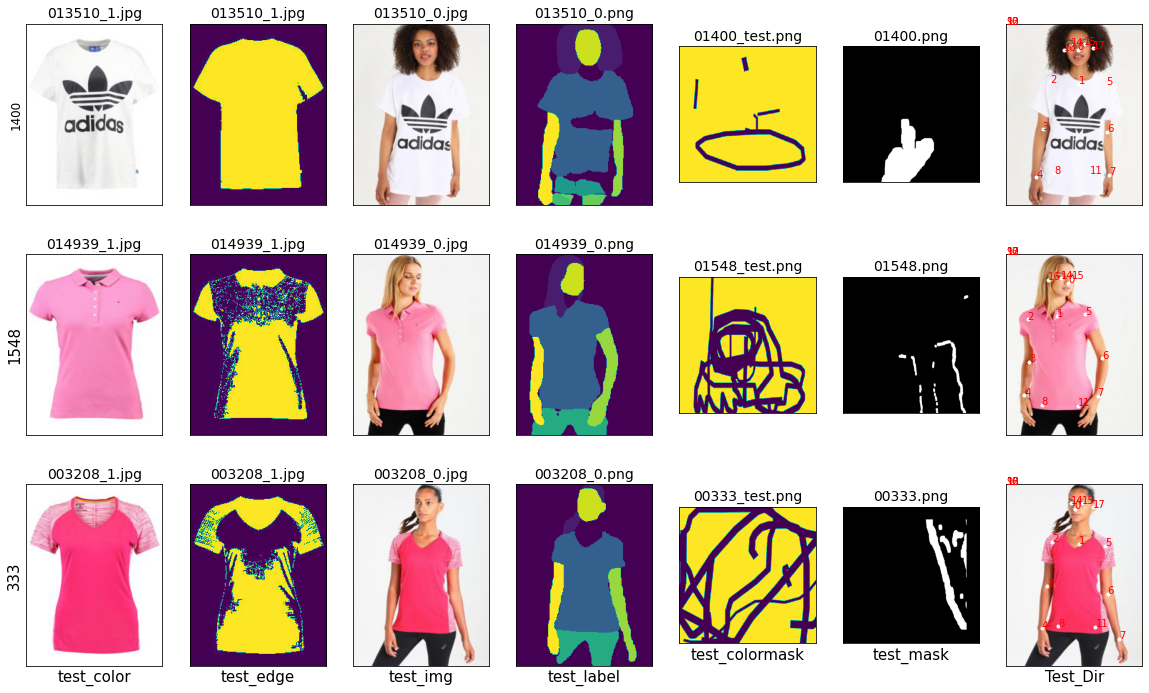

In [307]:
visualize_vton_dataset_imgs(vton_test_dir, 2032, 3, (20, 12))

In [308]:
def get_img_and_label_by_index(dir_path, index=0):

  test_img = get_file_paths_at_index(dir_path, index)[3]
  test_label = get_file_paths_at_index(dir_path, index)[4]

  # visulaize one image sample
  test_img_plt = mpimg.imread(test_img)
  imgplot_0 = plt.imshow(test_img_plt)
  plt.show()

  # visulaize one image sample
  test_label_plt = mpimg.imread(test_label)
  imgplot_1 = plt.imshow(test_label_plt)
  plt.show()

  return test_img, test_label

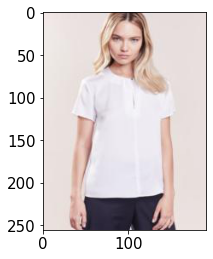

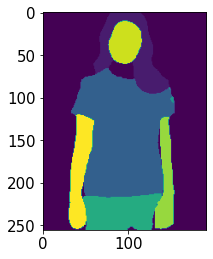

('/content/VTON/Test_Dir/test_img/000164_0.jpg',
 '/content/VTON/Test_Dir/test_label/000164_0.png')

In [309]:
img, label = get_img_and_label_by_index(vton_test_dir, 16)

img, label

#**Stage 2: Human Body Parsing**

The human parser is used to create data to train U-Net++, to segment the garments from the models, and to remove the head from the models.

In [310]:
%%time
# MHP Dataset Directory

if is_download_mhp_dataset:

  !wget https://drive.google.com/file/d/1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn/view
  !gdown 1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn

  # jar command is used becauze extracted result was too large for zip command to handle
  !jar xf /content/LV-MHP-v2.zip

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [311]:
def move_all_files_and_sub_dirs(source, destination):

  """
  Moves all files and sub-directories at root level of a directory to another place 
  along with all there contents
  """

  root_dir = list(os.walk(source))[0][0]
  sub_dir_and_files = [os.path.join(root_dir, i) for i in (list(os.walk(source))[0][1] + list(os.walk(source))[0][2])]

  for item in sub_dir_and_files:

    shutil.move(item, destination)

In [312]:
%%time
if is_download_cihp_dataset:

  !wget https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
  !gdown 1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

  !unzip -q /content/instance-level-human-parsing.zip -d CIHP

  # Remove ATR dataset as we do not need it
  shutil.rmtree('/content/CIHP/ICCV15_fashion_dataset(ATR)')

  # Move CIHP dataset folders from tree of sub-dirs to dir "/content/CIHP"
  move_all_files_and_sub_dirs('/content/CIHP/instance-level_human_parsing/instance-level_human_parsing', '/content/CIHP')

  # Remove empty directories from dataset
  shutil.rmtree('/content/CIHP/instance-level_human_parsing') 

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


**CIHP Dataset**

**Images:**



1.   **Category_ids:** Semantic part segmentation labels. Normalized grey scale masks for objects with pixel values from 0-19, as there are total 20 classes.

2.   **Categories:** Visualized semantic part segmentation labels. Non-normalized RGB masks for objects.

3.   **Human_ids:** Semantic person segmentation labels. Normalized grey scale masks for humans. Every image contains grey scale values equal to number of humans.

4.   **Human:** Visualized semantic person segmentation labels. Non-normalized RGB masks for humans.

5.   **Instance_ids:** Instance-level human parsing labels. Same body parts of different humans in the image will have different masks, so total number of colors will be (no. of humans x no. of class of objects). WE WILL NOT USE THIS DATA FOR OUR PROBLEM.  

6.   **Instances:** Visualized instance-level human parsing labels. Same as Instance_ids, but have non-normalized RGB images. WE WILL NOT USE THIS DATA FOR OUR PROBLEM. 

7.   **Images:** The input image data.

**Label order of semantic part segmentation:**

1.  Hat 
2.  Hair 
3.  Glove 
4.  Sunglasses 
5.  UpperClothes 
6.  Dress 
7.  Coat 
8.  Socks 
9.  Pants 
10. Torso-skin 
11. Scarf 
12. Skirt 
13. Face 
14. Left-arm 
15. Right-arm 
16. Left-leg 
17. Right-leg 
18. Left-shoe 
19. Right-shoe
20. Background

In [313]:
cihp_test_dir = '/content/CIHP/Testing'
cihp_train_dir = '/content/CIHP/Training'
cihp_valid_dir = '/content/CIHP/Validation'

In [314]:
def visualize_cihp_dataset_imgs(root_dir, n_samples=3, figsize=(20, 12)):
 
  # create figure
  fig = plt.figure(figsize=figsize)
  
  # setting values to rows and column variables
  rows = n_samples
  columns = len(list(os.walk(root_dir))[0][1])
  max_range = len(os.listdir(os.path.join(root_dir, list(os.walk(root_dir))[0][1][0]))) - 1

  index = 0

  for row_num in range(rows):

    random_index = randrange(max_range)
    
    visualize_paths = get_file_paths_at_index(root_dir, random_index)
  
    img_read_array = []
    
    # create a dictionary containing read image data and image info
    for img_path in visualize_paths:
      
      # img_test = cv2.imread(img_path)
      img = {'img': mpimg.imread(img_path), 'img_name': img_path.split("/")[4], 'file_name': img_path.split("/")[5]}
      img_read_array.append(img)



    # display dictionary of images on a grid
    for img_read_data in img_read_array:

      index += 1

      fig.add_subplot(rows, columns, index,)

      # styling
      plt.rc('font', size=15) 
      # plt.rc('title', size=12)

      plt.imshow(img_read_data['img'])
      plt.title(img_read_data['file_name'], fontdict={'fontsize': 14})

      # remove axes on individual images
      plt.xticks([])
      plt.yticks([])

      
      if index%columns == 1:
        plt.ylabel(str(random_index))

      if row_num == rows-1:
        plt.xlabel(img_read_data['img_name'])



In [315]:
# Check number of files and directories in test directory 

get_dir_n_files(cihp_test_dir)

,Directoy Path,Sub Directories,Number of Files
0,/content/CIHP/Testing,[Images],1
1,/content/CIHP/Testing/Images,[],5000


In [316]:
# Check number of files and directories in train directory 

get_dir_n_files(cihp_train_dir)

,Directoy Path,Sub Directories,Number of Files
0,/content/CIHP/Training,"[Human_ids, Instances, Images, Categories, Cat...",1
1,/content/CIHP/Training/Human_ids,[],28280
2,/content/CIHP/Training/Instances,[],28280
3,/content/CIHP/Training/Images,[],28280
4,/content/CIHP/Training/Categories,[],28280
5,/content/CIHP/Training/Category_ids,[],28280
6,/content/CIHP/Training/Instance_ids,[],28280
7,/content/CIHP/Training/Human,[],28280


In [317]:
# Check number of files and directories in validation directory 

get_dir_n_files(cihp_valid_dir)

,Directoy Path,Sub Directories,Number of Files
0,/content/CIHP/Validation,"[Human_ids, Instances, Images, Categories, Cat...",1
1,/content/CIHP/Validation/Human_ids,[],5000
2,/content/CIHP/Validation/Instances,[],5000
3,/content/CIHP/Validation/Images,[],5000
4,/content/CIHP/Validation/Categories,[],5000
5,/content/CIHP/Validation/Category_ids,[],5000
6,/content/CIHP/Validation/Instance_ids,[],5000
7,/content/CIHP/Validation/Human,[],5000


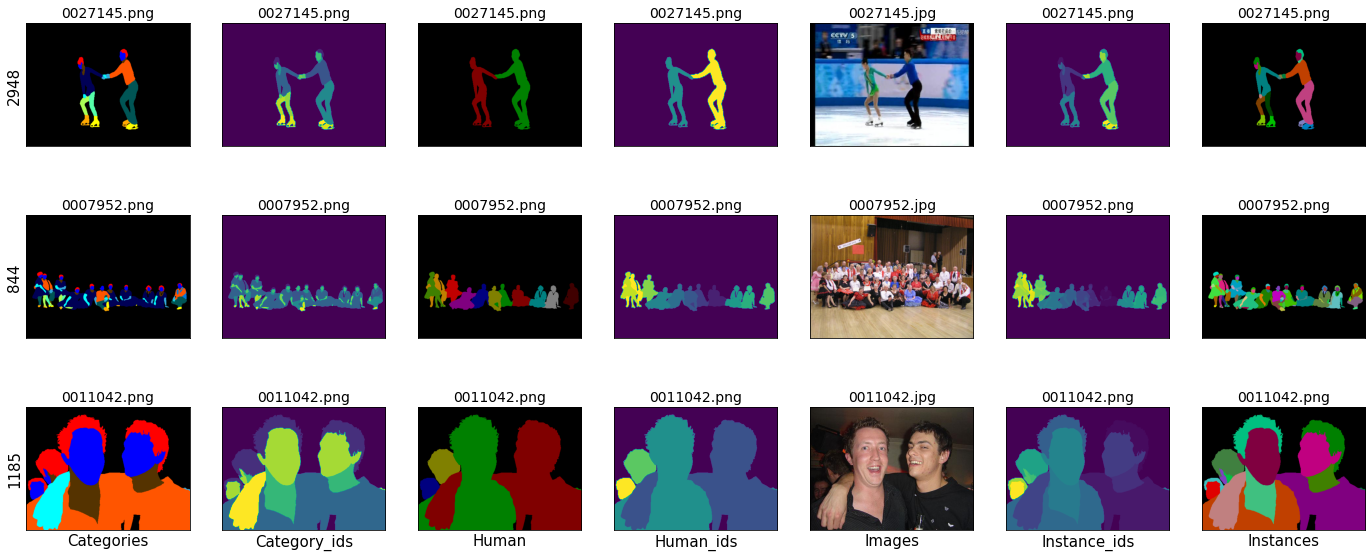

In [318]:
visualize_cihp_dataset_imgs(cihp_valid_dir, n_samples=3, figsize=(24,10))

In [319]:
cihp_test_dir, cihp_train_dir, cihp_valid_dir

('/content/CIHP/Testing', '/content/CIHP/Training', '/content/CIHP/Validation')

In [320]:
def mean_img_dims(dir_path):

  """
  Output: it will be in form of (h, w, c), 
  beacause it was extracted using shape function
  """

  img_files = None

  for _, _, files in os.walk(dir_path):

    img_files = [os.path.join(dir_path, s) for s in files]

  img_files_shape = [cv2.imread(i).shape for i in img_files]

  h = [i[0] for i in img_files_shape]
  w = [i[1] for i in img_files_shape]
  c = [i[2] for i in img_files_shape]

  mean_dim = (int(np.mean(h, axis=0)), int(np.mean(w, axis=0)), int(np.mean(c, axis=0)))

  return mean_dim

In [321]:
%%time
# test dir dimensions mean: (376, 462, 3)
if check_dims_for_cihp_dataset:
  print(mean_img_dims(os.path.join(cihp_test_dir, 'Images')))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [322]:
%%time
# train dir dimensions mean: (378, 459, 3)
if check_dims_for_cihp_dataset:
  print(mean_img_dims(os.path.join(cihp_train_dir, 'Images')))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [323]:
%%time
# valid dir dimensions mean: (377, 460, 3)
if check_dims_for_cihp_dataset:
  print(mean_img_dims(os.path.join(cihp_valid_dir, 'Images')))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


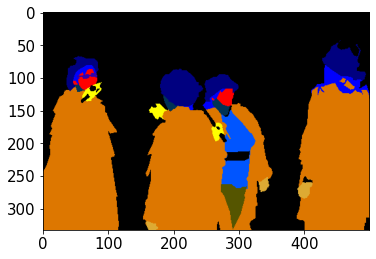

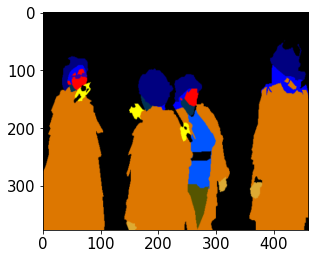

((333, 500, 3), (377, 460, 3))

In [324]:
img_test_1 = cv2.imread('/content/CIHP/Validation/Categories/0014883.png')
img_test_2 = cv2.imread('/content/CIHP/Validation/Images/0014883.jpg')

# cv2 works with (W, H)
img_test_3 = cv2.resize(img_test_1, (460, 377))

plt.imshow(img_test_1)
plt.show()

plt.imshow(img_test_3)
plt.show()

img_test_1.shape, img_test_3.shape

**UNET model implementation:**



*   The left side of this model represents "encoder" part, in the middle there is a bridge made with conv layers, and at the right side we have "decoder" part
*   In the encoder part we will reduce image dimensions and increase number of filters
*   In the decoder part we will increase image dimensons and reduce number of filters

*   We will be making predictions for every pixel of the input image at the output
*   At the output we will use "softmax" activation with "20" filters, because we want to have 20 class of segemntation and each filter will represent 1 class

*   Conv2D: Creates filters from input images equal to the given value. It is used to detect features in encoding part.

*   MaxPool2D: Reduces dimensions by a given factor. Like (2, 2) will reduce it by half

*   Conv2DTranspose: Creates filters from input images equal to the given value and reduces image dimensions due to the use of kernal size = 2 and stride = 2. It is used to construct features to make the image.




![image.png](https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [325]:
#  we will use input shape of (378, 459, 3) or (512, 512, 3) as it is the closest multiple of 2 to our data, 
# beacuse this is the mean of training images shape

# UNET Model

from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose, MaxPool2D, Activation, BatchNormalization, Conv2D 

def conv_block(input, n_filter):

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, n_filter):

  s = conv_block(input, n_filter)
  p = MaxPool2D(pool_size=(2, 2))(s)

  return s, p

def decoder_block(input, skip_input, n_filter):

  # Conv2DTranspose's main purpose is to increase dimensions (by factor 2 as stride = 2),
  # but it also reduces filters by a factor of 2

  # (None, 32, 32, 1024)
  x = Conv2DTranspose(filters = n_filter, kernel_size = 2, strides=2, padding='same')(input)
  
  # x:  (None, 64, 64, 512)
  # s:  (None, 64, 64, 512)
  x = Concatenate()([x, skip_input])

  # (None, 64, 64, 1024)
  x = conv_block(x, n_filter)

  # (None, 64, 64, 512)
  return x


def build_unet_model(input_shape = (512, 512, 3), n_classes = 20):
  # exact mean input shape
  # input = Input(shape = (378, 459, 3))

  # closest to mean input shape
  # input = Input(shape = (400, 480, 3))

  # also working input
  # input = Input(shape = (320, 416, 3))

  # paper's input shape
  # input = Input(shape = (512, 512, 3))

  input = Input(shape = input_shape)

  # encoding
  s1, p1 = encoder_block(input, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  # bridging
  b1 = conv_block(p4, 1024)

  # decoding
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  # every filter represents a segmented object
  # softmax activation is used beacuse we will be doing multi class classification on every pixel
  output_layer = Conv2D(filters = n_classes, kernel_size = 1, padding='same')(d4)
  output = Activation('softmax', dtype=tf.float32)(output_layer)

  model_parsing_0 = tf.keras.Model(inputs=input, outputs=output, name="human_parsing_model")

  print(model_parsing_0.input), print(model_parsing_0.output)

  return model_parsing_0

Height and Width of image must be divisible by 2, otherwise there will be problem with concatinate layer in model 

*   CLASSLABELS: class label in sequential order
*   COLORMAP: RGB code for respective class in the CLASSES array
*   N_CLASSES: number of total classes

In [326]:
IMG_HEIGHT = 400
IMG_WIDTH = 480
N_CHANNELS = 3

N_CLASSES = 20

In [327]:
model_parsing_0 = build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), n_classes=N_CLASSES)

KerasTensor(type_spec=TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 480, 20), dtype=tf.float32, name=None), name='activation_75/Softmax:0', description="created by layer 'activation_75'")


In [328]:
model_parsing_0.summary()

Model: "human_parsing_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 400, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 400, 480, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_55 (BatchN  (None, 400, 480, 64  256        ['conv2d_58[0][0]']              
 ormalization)                  )                                               

In [329]:
# visualize a plot of model
# tf.keras.utils.plot_model(model_parsing_0, show_shapes=True,)

In [330]:
cihp_test_dir, cihp_train_dir, cihp_valid_dir

('/content/CIHP/Testing', '/content/CIHP/Training', '/content/CIHP/Validation')

In [331]:
# we will be using already normalized dataset

images_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Images'))
masks_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Categories'))

images_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Images'))
masks_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Categories'))

images_test = get_files_in_dir(os.path.join(cihp_test_dir, 'Images'))

print(len(images_train), len(masks_train), len(images_valid), len(masks_valid), len(images_test))


# check if order of images and masks is the same
for _ in range(5):
  check_order_rand_index = randrange(len(images_train)-1)
  print(images_train[check_order_rand_index], masks_train[check_order_rand_index])

  check_order_rand_index = randrange(len(images_valid)-1)
  print(images_valid[check_order_rand_index], masks_valid[check_order_rand_index])

28280 28280 5000 5000 5000
0021867.jpg 0021867.png
0037867.jpg 0037867.png
0002448.jpg 0002448.png
0008795.jpg 0008795.png
0012423.jpg 0012423.png
0024313.jpg 0024313.png
0023974.jpg 0023974.png
0020151.jpg 0020151.png
0014571.jpg 0014571.png
0000256.jpg 0000256.png


In [332]:
def merge_two_list(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [333]:
def shuffle_and_ratio_data(images, masks, image_root_path, mask_root_path, dataset_ratio=1):

  images_len = len(images)
  masks_len = len(masks)

  # make image and masks tuples, shuffle the data and then return given percentage of that data
  image_mask_tuples = merge_two_list(images, masks)
  shuffle(image_mask_tuples)
  image_mask_tuples_per = image_mask_tuples[:int(images_len * dataset_ratio)]

  images_result = [os.path.join(image_root_path, x[0]) for x in image_mask_tuples_per]
  masks_result = [os.path.join(mask_root_path,x[1]) for x in image_mask_tuples_per]

  return images_result, masks_result

In [334]:
train_x, train_y = shuffle_and_ratio_data(images_train, masks_train, image_root_path='/content/CIHP/Training/Images', mask_root_path='/content/CIHP/Training/Categories', dataset_ratio=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False,)

valid_x, valid_y = shuffle_and_ratio_data(images_valid, masks_valid, image_root_path='/content/CIHP/Validation/Images', mask_root_path='/content/CIHP/Validation/Categories', dataset_ratio=0.1)

len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(2262, 2262, 566, 566, 500, 500)

In [335]:
for _ in range(5):

  i = randrange(len(train_x)-1)
  print(train_x[i], train_y[i])

  j = randrange(len(valid_x)-1)
  print(valid_x[j], valid_y[j])

  k = randrange(len(test_x)-1)
  print(test_x[j], test_y[j])

/content/CIHP/Training/Images/0020962.jpg /content/CIHP/Training/Categories/0020962.png
/content/CIHP/Validation/Images/0036967.jpg /content/CIHP/Validation/Categories/0036967.png
/content/CIHP/Training/Images/0016205.jpg /content/CIHP/Training/Categories/0016205.png
/content/CIHP/Training/Images/0016597.jpg /content/CIHP/Training/Categories/0016597.png
/content/CIHP/Validation/Images/0034340.jpg /content/CIHP/Validation/Categories/0034340.png
/content/CIHP/Training/Images/0007722.jpg /content/CIHP/Training/Categories/0007722.png
/content/CIHP/Training/Images/0035657.jpg /content/CIHP/Training/Categories/0035657.png
/content/CIHP/Validation/Images/0037989.jpg /content/CIHP/Validation/Categories/0037989.png
/content/CIHP/Training/Images/0001898.jpg /content/CIHP/Training/Categories/0001898.png
/content/CIHP/Training/Images/0034198.jpg /content/CIHP/Training/Categories/0034198.png
/content/CIHP/Validation/Images/0018882.jpg /content/CIHP/Validation/Categories/0018882.png
/content/CIHP/Tr

In [336]:
def get_color_map_and_labels():

  # class labels
  class_labels = [
      "Background",
      "Hat",
      "Hair", 
      "Glove", 
      "Sunglasses", 
      "UpperClothes", 
      "Dress", 
      "Coat", 
      "Socks", 
      "Pants", 
      "Torso-skin", 
      "Scarf", 
      "Skirt", 
      "Face", 
      "Left-arm", 
      "Right-arm", 
      "Left-leg", 
      "Right-leg", 
      "Left-shoe", 
      "Right-shoe",
  ]

  # color map
  # by default color map in given file is in bgr formate
  color_map_array = scipy.io.loadmat('/content/CIHP/human_colormap.mat')['colormap']

  bgr_color_map = np.array(color_map_array*256, dtype=np.uint8)

  rgb_color_map = np.array([[i[2], i[1], i[0]] for i in bgr_color_map])

  return class_labels, bgr_color_map, rgb_color_map

In [337]:
class_labels, bgr_color_map, rgb_color_map = get_color_map_and_labels()

# class_labels, bgr_color_map, rgb_color_map

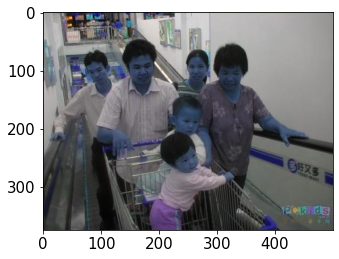

(375, 500, 3)
0 255


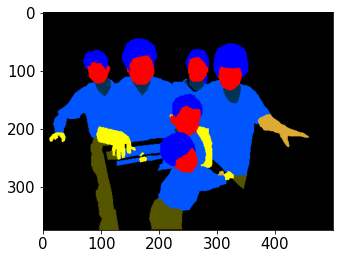

(375, 500, 3)
0 255


In [338]:
imread_x_test = cv2.imread(train_x[10])

plt.imshow(imread_x_test)
plt.show()

print(imread_x_test.shape)
print(np.amin(imread_x_test), np.amax(imread_x_test))

imread_y_test = cv2.imread(train_y[10])

plt.imshow(imread_y_test)
plt.show()

print(imread_y_test.shape)
print(np.amin(imread_y_test), np.amax(imread_y_test))

In [339]:
def process_image_and_mask(image_path, mask_path):

  image = cv2.imread(image_path)
  image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)
  image = image/255. 
  image = image.astype(np.float32)

  mask = cv2.imread(mask_path)
  mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)

  # mask normalization is different from simply /255, below we are doing mask normalization
  mask_objects = []
  for color in rgb_color_map:
    # we are setting cmap (binary mask) values to true where ever the color maches the color on mask
    # in this way we will get 20 images each of which shows an object, for every mask image
    # and we are doing this for all pixels
    cmap = np.all(np.equal(mask, color), axis=-1)
    mask_objects.append(cmap)

  # stack adds a new dimension to the array and stacks all images into a single array
  # it makes 20 images of (400, 480) into an array of (400, 480, 20)
  # (400, 480, 20) => this gives one-hot encoding where out of 20 items in the array any one is 1 which shows class value
  # we are doing this one-hot encoding thing beacuse this gives good results for training
  mask_stack = np.stack(mask_objects, axis=-1)
  mask_stack = mask_stack.astype(np.uint8)

  return image, mask_stack

In [340]:
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image, mask_stack = process_image_and_mask(x, y)
        return image, mask_stack

    image, mask_stack = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    mask_stack.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])

    return image, mask_stack

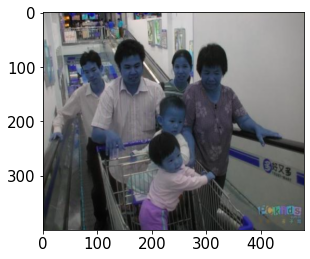

(400, 480, 3)
0.0 1.0


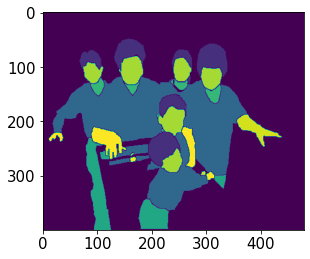

(400, 480)
0 15


In [341]:
def visualize_process_image_and_mask(image, mask_stack):

  plt.imshow(image)
  plt.show()

  print(image.shape)
  print(np.amin(image), np.amax(image))

  # this will convert on-hot encoded (400, 480, 20) to a normalized (400, 480) image
  mask_normaized = np.argmax(mask_stack, axis=-1)

  plt.imshow(mask_normaized)
  plt.show()

  print(mask_normaized.shape)
  print(np.amin(mask_normaized), np.amax(mask_normaized))

image, mask_stack = process_image_and_mask(train_x[10], train_y[10])
visualize_process_image_and_mask(image, mask_stack)

In [342]:
# create the pipeline

def tf_dataset(image_paths, mask_paths, batch_size=16):

  return tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [343]:
train_data = tf_dataset(train_x, train_y)
valid_data = tf_dataset(valid_x, valid_y)
test_data = tf_dataset(test_x, test_y)

train_data, valid_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 20), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 20), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 20), dtype=tf.uint8, name=None))>)

In [344]:
# for x, y in train_data:
  
#   # plt.imshow(x[0])
#   # plt.show()

#   # print(np.reshape(y[0], shape=(400, 180)).shape)
#   test_y = tf.reshape(y[0], shape=(20, 400, 480))[2]
#   # print()
#   # print(y[13])
#   plt.imshow(test_y)
#   plt.show()

#   break;

In [345]:
len(train_data), len(valid_data)

(142, 32)

In [346]:
# shutil.rmtree('/content/saved_models')

In [347]:
1e-3

0.001

In [348]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

if run_model_parsing_0:

  model_parsing_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])

  callbacks = [
      ModelCheckpoint(os.path.join(saved_models_path, 'model_parsing_0_0.h5'), save_best_only=True, save_weights_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
      EarlyStopping(monitor='val_loss', patience=2),
  ]

  model_parsing_0.fit(train_data, steps_per_epoch=len(train_data),
                      validation_data=valid_data, validation_steps=len(valid_data),
                      epochs=5, verbose=2, batch_size=16, callbacks=callbacks)
  
  model_parsing_0.save(os.path.join(saved_models_path,'model_parsing_0_1.h5'))

In [349]:
from keras.models import load_model

model_parsing_0 = load_model('model_parsing_0_0.h5')

model_parsing_0.summary()

Model: "human_parsing_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 400, 480, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 400, 480, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                               

In [350]:
test_x[0]

'/content/CIHP/Training/Images/0023361.jpg'

In [351]:
def grayscale_to_rgb(mask_grey_scale, classes, color_map):
    h, w = mask_grey_scale.shape
    mask_grey_scale = mask_grey_scale.astype(np.int32)
    mask_rgb = []

    # flatten the grey-scale image and map every pixel to colormap and then re-construct the rgb mask image
    for i, px in enumerate(mask_grey_scale.flatten()):
        mask_rgb.append(color_map[px])

    mask_rgb = np.reshape(mask_rgb, (h, w, 3))
    return mask_rgb

In [352]:
def pred_human_parsing(image_path, mask_path):

  image, mask_stack = process_image_and_mask(image_path, mask_path)

  # visualize_process_image_and_mask(image, mask_stack)

  # make image ready for prediction, we are doing this because for prediciton our data must be inside an array
  image = np.expand_dims(image, axis=0)

  # make mask ready for prediction, this will convery on-hot encoded mask back to grey scale image with values 0-19
  mask_onehot = np.argmax(mask_stack, axis=-1)
  mask_onehot = mask_onehot.astype(np.int32)

  true_mask = mask_onehot

  # make prediction and convert one-hot encoded result to image grey scale 0-19
  pred_mask = model_parsing_0.predict(image, verbose=0)[0]
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask.astype(np.float32)

  return pred_mask, true_mask

([], <a list of 0 Text major ticklabel objects>)

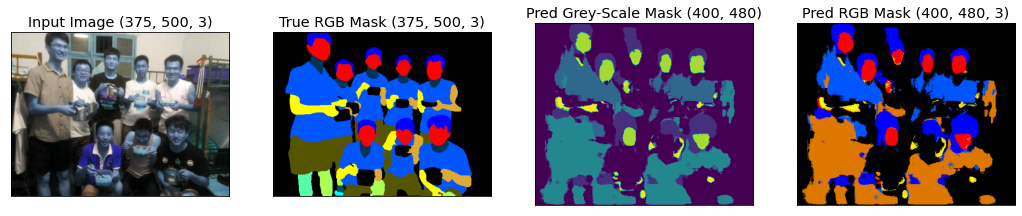

In [353]:
random_index = randrange(len(test_x)-1)

pred_mask, true_mask = pred_human_parsing(test_x[random_index], test_y[random_index])

fig = plt.figure(figsize=(18, 12))

plt.rc('font', size=12) 


ax1  = fig.add_subplot(1, 4, 1,)
visual_x = cv2.imread(test_x[random_index])
ax1.imshow(visual_x)
ax1.set_title('Input Image %s' % str(visual_x.shape))

plt.xticks([])
plt.yticks([])


ax2 = fig.add_subplot(1, 4, 2,)
true_mask_rgb = cv2.imread(test_y[random_index])
ax2.imshow(true_mask_rgb)
ax2.set_title('True RGB Mask %s' % str(true_mask_rgb.shape))

plt.xticks([])
plt.yticks([])


ax3 = fig.add_subplot(1, 4, 3,)
ax3.imshow(pred_mask)
ax3.set_title('Pred Grey-Scale Mask %s' % str(pred_mask.shape))

plt.xticks([])
plt.yticks([])


ax4 = fig.add_subplot(1, 4, 4,)
pred_mask_rgb = grayscale_to_rgb(pred_mask, class_labels, rgb_color_map)
ax4.imshow(pred_mask_rgb)
ax4.set_title('Pred RGB Mask %s' % str(pred_mask_rgb.shape))

plt.xticks([])
plt.yticks([])